In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#  The schema and table can be viewed at https://sqliteonline.com/
#  Or by installing DB Browser for SQLite
dict(Measurement.__table__.columns)

{'id': Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 'station': Column('station', TEXT(), table=<measurement>),
 'date': Column('date', TEXT(), table=<measurement>),
 'prcp': Column('prcp', FLOAT(), table=<measurement>),
 'tobs': Column('tobs', FLOAT(), table=<measurement>)}

In [11]:
dict(Station.__table__.columns)

{'id': Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 'station': Column('station', TEXT(), table=<station>),
 'name': Column('name', TEXT(), table=<station>),
 'latitude': Column('latitude', FLOAT(), table=<station>),
 'longitude': Column('longitude', FLOAT(), table=<station>),
 'elevation': Column('elevation', FLOAT(), table=<station>)}

In [12]:
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x160fec12c88>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [13]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x160fec557b8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

# Exploratory Climate Analysis

In [14]:
from datetime import timedelta as td
lastyear = dt.date.today() - td(365)
#today = dt.date.today().strftime("%Y-%m-%d")

In [15]:
from sqlalchemy import and_
import matplotlib.dates as mdates
from matplotlib import style
style.use('fivethirtyeight')
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#  prec_data = session.query(Measurement.date > last_year).limit(5).all()
last_entry = session.query(Measurement).order_by(Measurement.date.desc())

#  Print the date from the last 15 entries
# for i in last_entry.limit(15).all():
#     print(i.date)

last_entry_year = last_entry.first().__dict__['date']
prev_year = (dt.datetime.strptime(last_entry_year, "%Y-%m-%d") -td(365)).strftime("%Y-%m-%d")
print(type(prev_year), prev_year)
prec_data = session.query(Measurement.date, Measurement.prcp).filter(
    and_(Measurement.date >= prev_year, Measurement.prcp != None))
# prec_data = session.query(Measurement).all()
x_val, y_val = zip(*prec_data)

<class 'str'> 2016-08-23


2021 2021 <class 'tuple'>


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


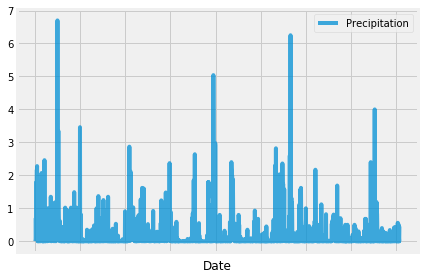

In [17]:
%matplotlib inline
# x_val = []
# y_val = []
# for i, j in prec_data:
#     x_val.append(dt.datetime.strptime(i, "%Y-%m-%d"))
#     y_val.append(j)
# Give our graph axis labels
# plt.xlabel("Date")
# plt.ylabel("Precipitation")
# plt.bar(x_val, y_val)
# plt.show()

print(len(x_val), len(y_val), type(x_val))

df = pd.DataFrame({"Date" : x_val,
                   "Precipitation" : y_val})
df.set_index('Date', inplace=True)
#df.sort_values(by=['Date'])
df.sort_index(inplace=True)
df.plot(alpha=0.75)
#df.to_csv("fileOne.csv", index=True, header=True)
# df1 = df.head(150)
# df1.plot(kind='bar', alpha=0.75, rot=30)
# plt.gca().xaxis_date()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
# plt.gcf().autofmt_xdate()
plt.tight_layout()
#  max(y_val)
# for p in prec_data:
#     print(p)
# a

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates
df.head()

In [19]:
# How many stations are available in this dataset?
total_stations = session.query(Station).count()
st = session.query(Station)
print(f"Total stations = {total_stations}")
print("Station names:")
for s in st:
    print(f"\t{s.name}")

Total stations = 9
Station names:
	WAIKIKI 717.2, HI US
	KANEOHE 838.1, HI US
	KUALOA RANCH HEADQUARTERS 886.9, HI US
	PEARL CITY, HI US
	UPPER WAHIAWA 874.3, HI US
	WAIMANALO EXPERIMENTAL FARM, HI US
	WAIHEE 837.5, HI US
	HONOLULU OBSERVATORY 702.2, HI US
	MANOA LYON ARBO 785.2, HI US


In [20]:
from sqlalchemy import func

# What are the most active stations?
# List the stations and the counts in descending order.
st_join = session.query(
    Station.id, Station.station, Station.name, func.count(Measurement.prcp).label('Count')
).join(
    # tell SQLAlchemy to join the tables without foreign key
    Measurement, Station.station == Measurement.station
).group_by(
    Station.name
).order_by(
    #  Forward reference to label attached above
sqlalchemy.desc('Count')
)

print('The Query is:')
print(st_join, '\n')
print(f"{'Station id':12}{'Station':15}{'Station Name':45}{'Observation Count'}")
print("".ljust(90,'='))
for st_id, st, st_name, meas_cnt in st_join:
    print(f"{st_id}{' ':11}{st:15}{st_name:45}{meas_cnt}")
print("".ljust(90,'='))


The Query is:
SELECT station.id AS station_id, station.station AS station_station, station.name AS station_name, count(measurement.prcp) AS "Count" 
FROM station JOIN measurement ON station.station = measurement.station GROUP BY station.name ORDER BY "Count" DESC 

Station id  Station        Station Name                                 Observation Count
7           USC00519281    WAIHEE 837.5, HI US                          2772
2           USC00513117    KANEOHE 838.1, HI US                         2696
1           USC00519397    WAIKIKI 717.2, HI US                         2685
6           USC00519523    WAIMANALO EXPERIMENTAL FARM, HI US           2572
9           USC00516128    MANOA LYON ARBO 785.2, HI US                 2484
3           USC00514830    KUALOA RANCH HEADQUARTERS 886.9, HI US       1937
8           USC00511918    HONOLULU OBSERVATORY 702.2, HI US            1932
4           USC00517948    PEARL CITY, HI US                            683
5           USC00518838    UP

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
act_st_id = st_join.first()
temp_q = session.query(
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
    func.max(Measurement.tobs)).filter(Measurement.station == act_st_id.station)
print(f"Station {act_st_id.station} {act_st_id.name} recorded")
min_t, avg_t, max_t = temp_q.first()
print(f"\t Lowest temp of {min_t:3.2f}°, avg temp of {avg_t:2.2f}° and max temp of {max_t:3.2f}°")

Station USC00519281 WAIHEE 837.5, HI US recorded
	 Lowest temp of 54.00°, avg temp of 71.66° and max temp of 85.00°


2017-08-18 2016-08-18 357


C:\Users\msatyana\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


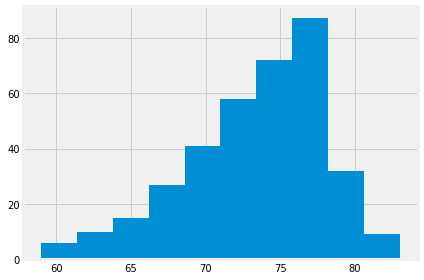

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_entry_act_st_q = session.query(Measurement).filter(
    Measurement.station == act_st_id.station).order_by(Measurement.date.desc())
last_entry = last_entry_act_st_q.first().date
prev_year = (dt.datetime.strptime(last_entry, "%Y-%m-%d") - td(365)).strftime("%Y-%m-%d")
temperature_data = session.query(Measurement.date, Measurement.tobs).filter(and_(
    Measurement.date >= prev_year,
    Measurement.station == act_st_id.station))
print(last_entry, prev_year, temperature_data.count())
temperature_obs = []
#h_file = open("hist_out.csv","w")
for i,j in temperature_data:
    temperature_obs.append(j)
#    h_file.write(i + "," + str(j) + "\n")
#h_file.close()
fig, axs = plt.subplots(1, 1, tight_layout=True)
#n_bins = 13

# We can set the number of bins with the `bins` kwarg
axs.hist(temperature_obs)
plt.show()

In [23]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin, tavg, tmax = calc_temps('2016-02-28', '2016-03-05')[0]
print("During trip from 2016-02-28 to 2016-03-05")
print(f"Min temperature was {tmin:3.2f}° Avg temperature was {tavg:3.2f}° Max temperature was {tmax:3.2f}°")

During trip from 2016-02-28 to 2016-03-05
Min temperature was 62.00° Avg temperature was 69.89° Max temperature was 80.00°


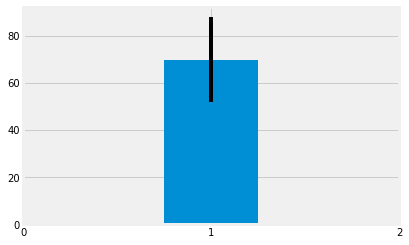

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(1, 1)
ax.bar(1, tavg, width=0.5, yerr=tmax-tmin)
ax.set_xlim(0, 2)
#ax.xaxis.set_major_formatter(plt.NullFormatter())
#ax.xaxis.set_major_locator(plt.NullLocator())
plt.xticks([0,1,2])
plt.show()

In [26]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#  Can be written as a sunction too. But for understanding sake it is
#  explicitly spelled out as a complex query
vacation_q = session.query(Measurement.prcp,
              Station.station,
              Station.name,
              Station.latitude,
              Station.longitude,
              Station.elevation).\
              join(Station, Station.station == Measurement.station).\
              filter(Measurement.date >= '2017-02-28').\
              filter(Measurement.date <= '2017-03-05').\
              filter(Measurement.prcp != None).\
              group_by(Station.station).\
              order_by(Measurement.prcp.desc())

print('The Query is:')
print(vacation_q, '\n')
print(f"{'Station':13}{'Station Name':42}{'Precp':7}{'Latitude':10}{'Longitude':10}{'Elevation':10}")
print("".ljust(91,'='))
for prcp, st, st_name, st_lat, st_lng, st_elev in vacation_q:
    print(f"{st:13}{st_name:42}{prcp:>5.2f}{st_lat:>10.2f}{st_lng:>10.2f}{st_elev:>10.1f}")
print("".ljust(91,'='))
# vacation_q.all()

The Query is:
SELECT measurement.prcp AS measurement_prcp, station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation 
FROM measurement JOIN station ON station.station = measurement.station 
WHERE measurement.date >= ? AND measurement.date <= ? AND measurement.prcp IS NOT NULL GROUP BY station.station ORDER BY measurement.prcp DESC 

Station      Station Name                              Precp  Latitude  Longitude Elevation 
USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US     1.12     21.52   -157.84       7.0
USC00519281  WAIHEE 837.5, HI US                        0.41     21.45   -157.85      32.9
USC00516128  MANOA LYON ARBO 785.2, HI US               0.35     21.33   -157.80     152.4
USC00519397  WAIKIKI 717.2, HI US                       0.35     21.27   -157.82       3.0
USC00517948  PEARL CITY, HI US                          0.14     21.39   -157.98   

## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
